# Factorizable Two Mode Squeezing in KTP

This example shows how to generate a factorizable, two mode squeezed state.
That is to say generate a pair of supermodes with negligible higher order modes.

This follows the theory of U'Ren et al. (https://arxiv.org/abs/quant-ph/0611019).

For similar experimental realizations, see eg https://doi.org/10.1364/OE.24.010869.

In [1]:
cd ../../src/NonlinearOptics/

/home/fpresutti/src/NonlinearOptics


In [2]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.linalg import circulant

from nonlinearmedium import Chi2PDCII

from materials import KTPy, KTPz

from poling import *
from classical import *
from multimode import *
from decompositions import bloch_messiah

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib notebook
plt.rcParams["figure.figsize"] = [9, 6]

In [4]:
c = 299792458 # m / s

Assume a ~200 fs Gaussian pulse for the pump.
We set the pump to around 790 nm, which will allow the signal and idler have approximately equal bandwidths.

In [5]:
signalWav = 1583 # nm <- A lucky number according to Sellmeier Eqns
pumpWav   = signalWav / 2 # nm

pumpFreq   = 2e-3 * np.pi * c / pumpWav   # 2pi THz
signalFreq = 2e-3 * np.pi * c / signalWav # 2pi THz

# Bandwidth limited pulse time scale
timeScale = 115e-3 # ps

# Crystal Parameters
Assume a KTP waveguide at room temperature, where the dispersion properties are the same as in bulk.

In [6]:
temperatureKTP = 22.5 # C
KTPd31 = 4.4  # pm / V

In [7]:
## y-axis, signal and pump
# Group Velocity Dispersion
beta2sE = 1e27 * KTPy.gvd(signalWav*1e-3, temperatureKTP) # ps^2 / km
beta2p  = 1e27 * KTPy.gvd(pumpWav*1e-3,   temperatureKTP) # ps^2 / km

# Relative Group Velocity
ngsE = KTPy.ng(signalWav*1e-3, temperatureKTP)
ngp  = KTPy.ng(pumpWav*1e-3,   temperatureKTP)

# Index of refraction
indexSE = KTPy.n(signalWav*1e-3, temperatureKTP)
indexP  = KTPy.n(pumpWav*1e-3,   temperatureKTP)

# TOD
beta3sE = 1e39 * KTPy.beta3(signalWav*1e-3, temperatureKTP) # ps^3 / km
beta3p  = 1e39 * KTPy.beta3(pumpWav*1e-3,   temperatureKTP) # ps^3 / km


## z-axis, signal
# Group Velocity Dispersion
beta2sO = 1e27 * KTPz.gvd(signalWav*1e-3, temperatureKTP) # ps^2 / km

# Group Velocity
ngsO = KTPz.ng(signalWav*1e-3, temperatureKTP)

# Index of refraction
indexSO = KTPz.n(signalWav*1e-3, temperatureKTP)

# TOD
beta3sO = 1e39 * KTPz.beta3(signalWav*1e-3, temperatureKTP) # ps^3 / km

In [8]:
# Walk-off
beta1p, beta1sE, beta1sO = findFrameOfReference(ngp, ngsE, ngsO) # ps / km

# Phase velocity mismatch
diffBeta0pdc = 2 * np.pi * (indexP / pumpWav - (indexSE + indexSO) / signalWav) * 1e12 # km^-1

Set some arbitrary pulse energy and waveguide dimensions.

The waveguide length is an important parameter, as it must be commensurate to the pump bandwidth and temporal walkoff, as shown later.

In [9]:
energy    = 5e-12 # J
peakPower = energy / (timeScale * 1e-12) # W

length    = 8.0e-3 # m
pulseRad  = 6.0e-7 # m

print("beam waist = {:0.0f} um".format(pulseRad * 1e6))

beam waist = 1 um


Normalized simulation Parameters:

In [10]:
# Characteristic lengths
DSL   = calculateDispLength(beta2p, timeScale, pulseTypeFWHM=None)
NLIIE = calculateChi2NlLength(KTPd31, peakPower, pulseRad, indexP, indexSE, signalFreq)
NLIIO = calculateChi2NlLength(KTPd31, peakPower, pulseRad, indexP, indexSO, signalFreq)

amplitudeRatio = NLIIE / NLIIO

# Normalized quantities
diffBeta0pdcN, (beta1pN, beta1sEN, beta1sON), (beta2sEN, beta2sON), (beta3pN, beta3sEN, beta3sON) = \
  normalizeDispersion(timeScale, DSL / 1000,
                      diffBeta0pdc,
                      (beta1p, beta1sE, beta1sO),
                      (beta2sE, beta2sO),
                      (beta3p, beta3sE, beta3sO))

relLength = length / DSL
relNlLengthE = NLIIE / DSL
relNlLengthO = NLIIO / DSL

pdcParams = {"relativeLength": relLength,
             "beta2":  np.sign(beta2p),
             "beta2s": beta2sEN,
             "beta2o": beta2sON,
             "beta3":  beta3pN,
             "beta3s": beta3sEN,
             "beta3o": beta3sON,
             "beta1":  beta1pN,
             "beta1s": beta1sEN,
             "beta1o": beta1sON,
             "diffBeta0": diffBeta0pdcN,
             "nlLengthI": relNlLengthE,
             "nlLengthII": relNlLengthO,
            }

# Simulation Axes

In [11]:
# nt works best as multiples of 2, 3 and 5
nt = 3**2 * 2**7
tMax = 225

# normalized
tau   = (2 * tMax / nt) * ifftshift(np.arange(-nt / 2, nt / 2))
omega = (-np.pi / tMax) *  fftshift(np.arange(-nt / 2, nt / 2))

wMax = np.max(omega)
angFreqMax = wMax / timeScale
freqMax = angFreqMax / (2 * np.pi)

# dimensionful
time    = tau * timeScale   # ps
angFreq = omega / timeScale # 2 pi THz
wavelengthP = 2e-3 * np.pi * c / (angFreq + pumpFreq) # nm
wavelengthS = 2e-3 * np.pi * c / (angFreq + signalFreq) # nm

# Parameters for two mode squeezing: spectrally factorable polarization states
As derived in U'Ren et al. 2005.

We need to match the pump bandwidth to the phase matching function.
We find how much we need to filter (pulse shape) the pump bandwidth to achieve factorizability.

With a Gaussian pump and Gaussian phase matching function we need:
$$1 + \sigma_p^2 \sigma_k^2 \Delta \beta_{1s} \Delta \beta_{1i} = 0$$

In [12]:
# Signal Walkoff Parameter
tauS = pdcParams["beta1s"] - pdcParams["beta1"]

# Idler Walkoff Parameter
tauI = pdcParams["beta1o"] - pdcParams["beta1"]

# Phase matching function width
sigmaPMF = 0.14 * pdcParams["relativeLength"]

# Pump width
sigmaPump = 1

# Match Pump to PMF:
sigma_ = sigmaPump * sigmaPMF * np.sqrt(np.abs(tauS * tauI))

print("Pump bandwidth correction factor:", sigmaPump / sigma_)

Pump bandwidth correction factor: 0.6963999289840028


In addtition, if the GVD is non-negligible in the medium, pre-chirping the pump is also necessary.

$$C = - L \beta_{2p} / 2$$

In [13]:
# Match Pump chirp to dispersion:
pumpPreChirp = -0.5 * pdcParams["relativeLength"] * pdcParams["beta2"]
print(pumpPreChirp)

-0.05999621978488649


# Poling
We want to engineer the phase-matching function to be Gaussian.

First compute periodic poling structure for reference:

In [14]:
squeezePoling = periodicPoling(pdcParams["diffBeta0"], pdcParams["relativeLength"])

In [15]:
print("Domain lengths: {:.3f} um".format(1e6 * squeezePoling[0] * length / pdcParams["relativeLength"]))
print("Number of domains in {:.1f}mm: {}".format(1e3 * length, squeezePoling.size))

Domain lengths: 23.805 um
Number of domains in 8.0mm: 337


Define the desired spatial-nonlinearity function (Gaussian)

In [16]:
pmfCenter = 0.5 * (pdcParams["relativeLength"] - squeezePoling[-1]
                   - (0 if (squeezePoling.size % 2) else squeezePoling[0]))

gaussianPolingFunc = lambda z: (
  np.exp(-0.5 * (z - pmfCenter)**2 / sigmaPMF**2)
)

# We will use this later
def gaussianPolingFunc_(startZ):
  return lambda z: (
    np.exp(-0.5 * (startZ + z - pmfCenter)**2 / sigmaPMF**2)
  )

<IPython.core.display.Javascript object>


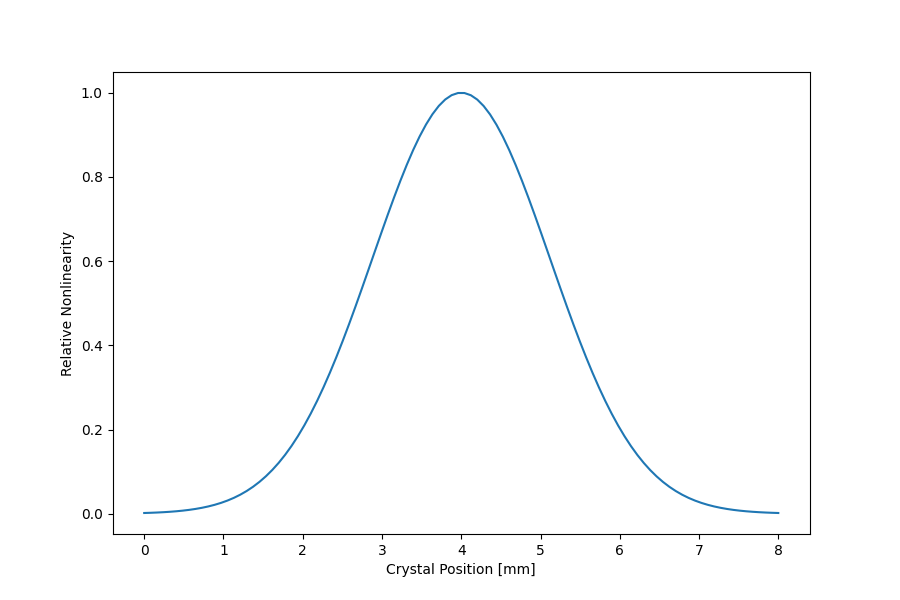

In [17]:
fig = plt.figure()
plt.plot(1e3 * np.linspace(0, length, 100),
         gaussianPolingFunc(np.linspace(0, pdcParams["relativeLength"], 100)))
plt.xlabel("Crystal Position [mm]")
plt.ylabel("Relative Nonlinearity");

For illustrative purposes: calculate structures for both the duty-cycle and deleted-domain poling strategy.

Define some arbitrary minimum domain size for the duty-cyle modulation.

In [18]:
minSize = 2e-6 / DSL # example value

dcSquzPoling = dutyCyclePmf(gaussianPolingFunc, pdcParams["diffBeta0"],
                            pdcParams["relativeLength"], minSize)

ddSquzPoling = deletedDomainPmf(gaussianPolingFunc, pdcParams["diffBeta0"],
                                pdcParams["relativeLength"])

Plot the structure for each one

<IPython.core.display.Javascript object>


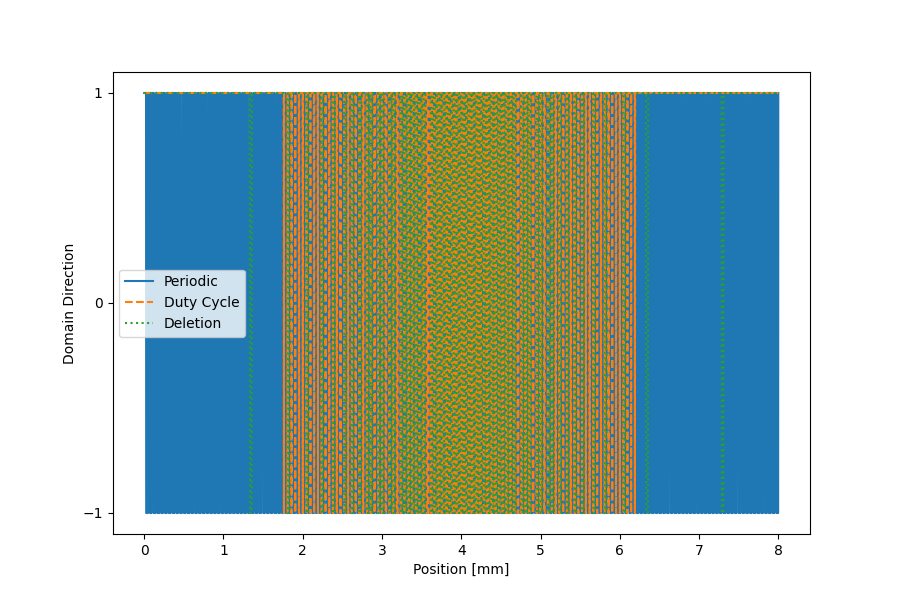

In [19]:
fig = plt.figure()
plt.plot(np.linspace(0, 1e3 * length,  50*squeezePoling.size),
         domainsToSpace(squeezePoling, 50*squeezePoling.size),
         "-", label="Periodic")
plt.plot(np.linspace(0, 1e3 * length, 50*dcSquzPoling.size),
         domainsToSpace(dcSquzPoling, 50*dcSquzPoling.size),
         "--", label="Duty Cycle")
plt.plot(np.linspace(0, 1e3 * length, 50*ddSquzPoling.size),
         domainsToSpace(ddSquzPoling, 50*ddSquzPoling.size),
         ":", label="Deletion")

plt.legend()
plt.xlabel("Position [mm]")
plt.ylabel("Domain Direction")
plt.yticks([-1, 0, +1]);

We can also make a poling pattern that combines duty cycle and domain deletion strategies (i.e. duty cycle pattern with domain deletion where the duty cycle becomes too small).

In [20]:
# deleted domain pmf using lowest allowed duty cycle
dddcSquzPolingStart = deletedDomainPmf(gaussianPolingFunc, pdcParams["diffBeta0"],
                                       dcSquzPoling[0],
                                       #dutyCycle=0.5 * minSize / squeezePoling[0],
                                       dutyCycle=0.5 * dcSquzPoling[1] / squeezePoling[0],
                                       normalize=False)

dddcSquzPolingEnd   = deletedDomainPmf(gaussianPolingFunc_(pdcParams["relativeLength"] - dcSquzPoling[-1]
                                                           - dcSquzPoling[-2]),
                                       pdcParams["diffBeta0"],
                                       dcSquzPoling[-1] + dcSquzPoling[-2],
                                       #dutyCycle=0.5 * minSize / squeezePoling[0],
                                       dutyCycle=0.5 * dcSquzPoling[1] / squeezePoling[0],
                                       normalize=False,
                                       override=True)

dddcSquzPoling = np.concatenate([dddcSquzPolingStart[:(-1 if (dddcSquzPolingStart[-1]<0.5*minSize) else None)],
                                 dcSquzPoling[1:-2],
                                 dddcSquzPolingEnd[:]])

<IPython.core.display.Javascript object>


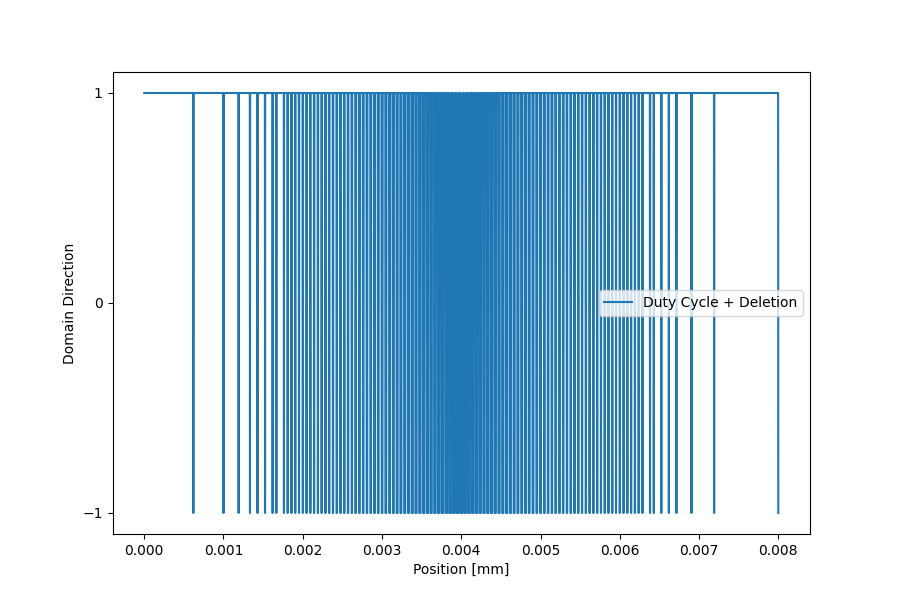

In [21]:
fig = plt.figure()
plt.plot(np.linspace(0, length, 50*dddcSquzPoling.size),
         domainsToSpace(dddcSquzPoling, 50*dddcSquzPoling.size),
         "-", label="Duty Cycle + Deletion")

plt.legend()
plt.xlabel("Position [mm]")
plt.ylabel("Domain Direction")
plt.yticks([-1, 0, +1]);

Compare the desired and designed nonlinearities by comparing the integral of the nonlinearity as a function of crystal position. 

<IPython.core.display.Javascript object>


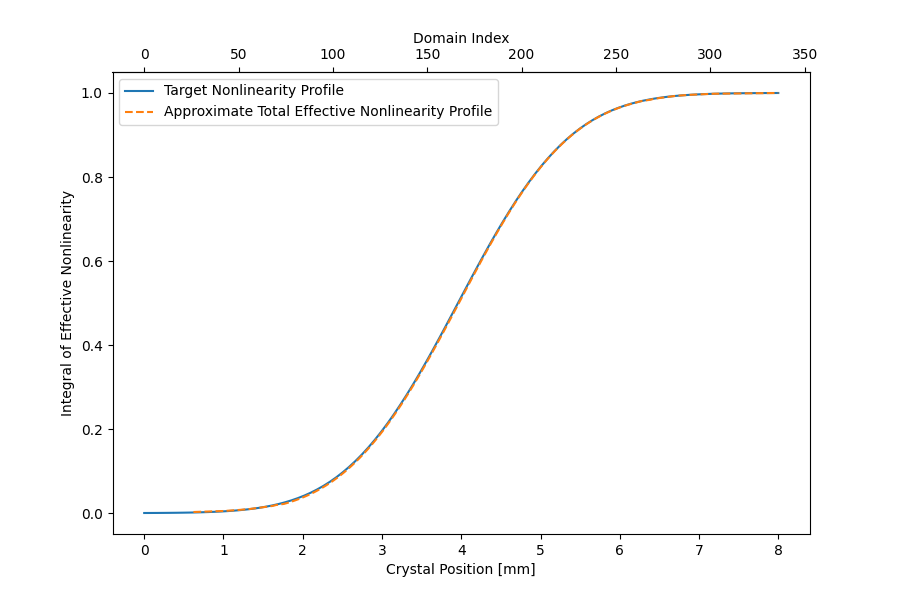

In [22]:
fig = plt.figure()

int1 = np.cumsum(gaussianPolingFunc(np.linspace(0, pdcParams["relativeLength"], 100)))
int2 = np.cumsum(np.sin((0.5 * np.pi / squeezePoling[0]) * dddcSquzPoling[1::2]))

plt.plot(np.linspace(0, 1e3 * length, 100),
         int1 / int1[-1],
         label="Target Nonlinearity Profile"
        )

plt.plot(
  (1e3 * DSL) *
  np.cumsum(np.sum(dddcSquzPoling[:(-1 if (dddcSquzPoling.size % 2) else None)].reshape(-1, 2), axis=-1)),
  int2 / int2[-1],
  "--", label="Approximate Total Effective Nonlinearity Profile"
)

fwd, bck = lambda x: x / (1e3 * length * squeezePoling[0] / pdcParams["relativeLength"]),\
           lambda x: x * (1e3 * length * squeezePoling[0] / pdcParams["relativeLength"])

ax = plt.gca()
secax = ax.secondary_xaxis("top", functions=(fwd, bck))
secax.set_xlabel("Domain Index")
  
plt.xlabel("Crystal Position [mm]")
plt.ylabel("Integral of Effective Nonlinearity")

plt.legend();

# Instantiate PDE Solver

In [23]:
params1 = {**pdcParams,
           "tPrecision": nt, "tMax": tMax,
           "zPrecision": int(15 * squeezePoling.size
                             * min(1, pdcParams["nlLengthI"])
                             / pdcParams["relativeLength"]),
           "poling": dddcSquzPoling,
          }

In [24]:
crystal = Chi2PDCII(**params1)

In [25]:
print("PDE grid dimensions (# space, # time):", crystal.signalFreq.shape)

PDE grid dimensions (# space, # time): (10020, 1152)


# Construct the pump spectrum
Tweak the bandwidth according to the condition previously calculated

In [26]:
pumpProfTemp = ifft(np.exp(-(0.5 * sigma_**2) * omega**2)
                  * np.exp(-0.5j * pumpPreChirp * omega**2))

pumpProfTemp *= 1 / np.max(np.abs(pumpProfTemp))

crystal.setPump(pumpProfTemp)

In [27]:
crystal.runPumpSimulation()

<IPython.core.display.Javascript object>


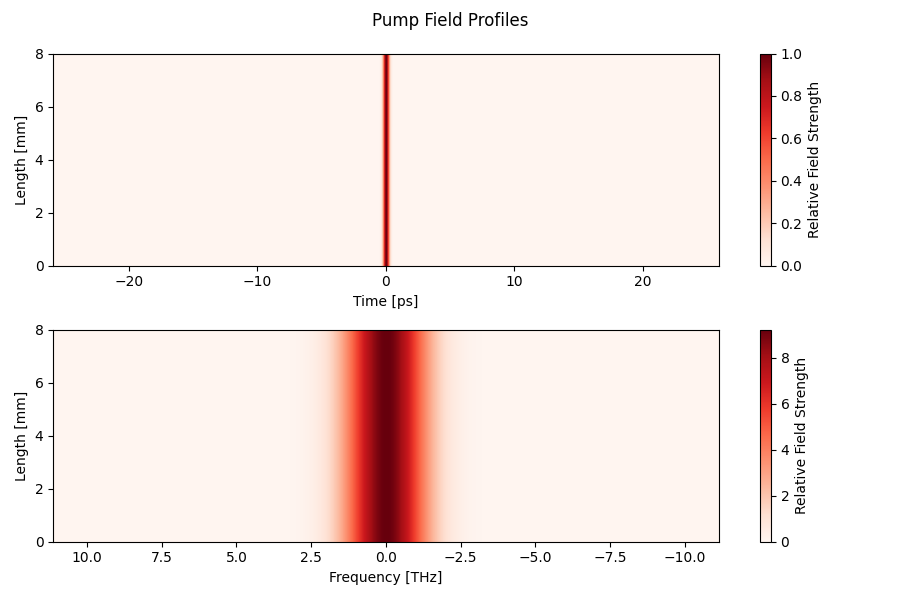

In [28]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.imshow(np.abs(fftshift(crystal.pumpTime[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[-tMax * timeScale, tMax * timeScale, 0, 1000 * length])
plt.colorbar().set_label("Relative Field Strength")
plt.xlabel("Time [ps]")
plt.ylabel("Length [mm]")

ax = fig.add_subplot(2, 1, 2)
plt.imshow(np.abs(fftshift(crystal.pumpFreq[::100], axes=1)), cmap="Reds", aspect="auto", origin="lower",
           extent=[freqMax, -freqMax, 0, 1000 * length])
plt.colorbar().set_label("Relative Field Strength")
plt.xlabel("Frequency [THz]")
plt.ylabel("Length [mm]")

plt.suptitle("Pump Field Profiles")
plt.tight_layout();

# Green's function calculation and decomposition

Compute $C, S$ Green's function matrices.

In [29]:
energies = np.arange(1, 2) # just compute one, but can compare as a function of pump power
Cs, Ss = [None] * len(energies), [None] * len(energies)

In [30]:
for i, relativeEnergy in enumerate(energies):
  # crystal.setPump(pumpProfTemp * np.sqrt(relativeEnergy))
  # crystal.runPumpSimulation()
  Cs[i], Ss[i] = crystal.computeGreensFunction(runPump=True, normalize=True,
                                               nThreads=40) # assuming a 40 physical core computer

Compute derivative quantities: photon (intensity) covariance matrix and the squeezing supermodes.

Note: energy/correlations appear in the corner, and are due to aliasing effects.
Therefore we trace out the outer edges.
(Need to be careful doint this as it can make the matrix non-symplectic and cause problems with the Bloch-Messiah decomposition.)

In [31]:
# Index masks for tracing edges:
mask = np.r_[nt//6 : 5*nt//6, nt + nt//6 : nt + 5*nt//6]
mask_ = np.r_[nt//6 : 5*nt//6]
trace = np.ix_(mask, mask)

nt_ = 2 * nt // 3
angFreqMax_ = angFreqMax * 5 / 6

In [32]:
# Joint Spectral Intensity
aCovMats = [calcCovarianceMtxABasis(C[trace], S[trace]) for C, S in zip(Cs, Ss)]

photonCovMatrix = (np.abs(aCovMats[-1][:2*nt_, :2*nt_]).real**2
                 + np.abs(aCovMats[-1][:2*nt_, 2*nt_:]).real**2 - 0.25 * np.eye(2*nt_))

# Bloch-Messiah in xp-basis
toXPTrans, frXPTrans = basisTransforms(2*nt_)
Zs = [calcQuadratureGreens(C[trace], S[trace]) for C, S in zip(Cs, Ss)]
decomps = [bloch_messiah(Z, tol=5e-4) for Z in Zs]
abases = [(frXPTrans @ decomp[0] @ toXPTrans)[:2*nt_, :2*nt_].T for decomp in decomps]
diags = [decomp[1].diagonal() for decomp in decomps]

Plot the photon-number covariance matrix, or joint-spectral intensity.

<IPython.core.display.Javascript object>


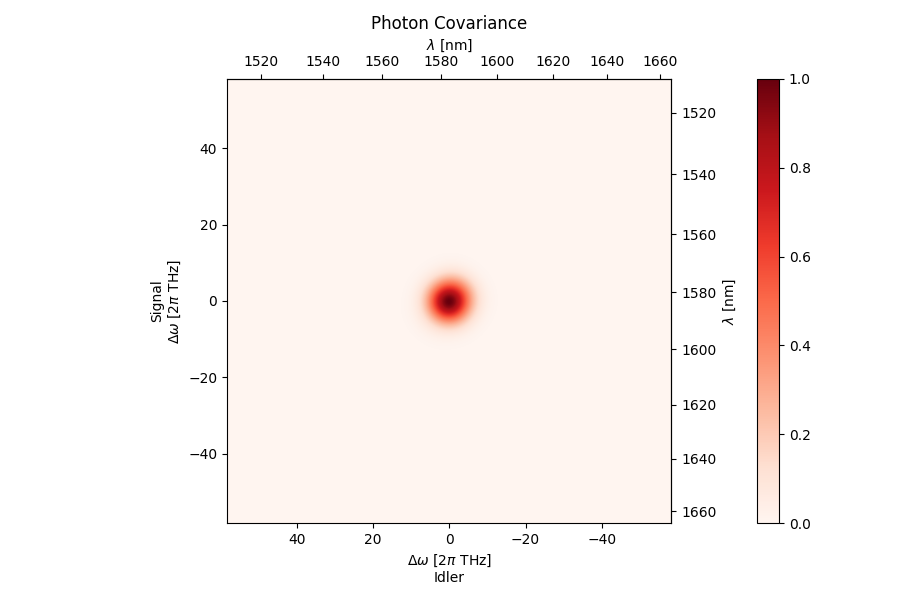

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [33]:
fig = plt.figure()

plt.imshow(photonCovMatrix[nt_:, :nt_] / photonCovMatrix[nt_:, :nt_].max(), "Reds",
           extent=[angFreqMax_, -angFreqMax_, -angFreqMax_, angFreqMax_])

plt.title("Photon Covariance")
plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]\nIdler")
plt.ylabel("Signal\n$\Delta \omega$ [$2 \pi$ THz]")

fwd, bck = lambda x: 2e-3 * np.pi * c / (x + signalFreq),\
           lambda x: 2e-3 * np.pi * c / x - signalFreq

ax = plt.gca()
secax = ax.secondary_xaxis("top", functions=(fwd, bck))
secax.set_xlabel("$\lambda$ [nm]")
secax = ax.secondary_yaxis("right", functions=(fwd, bck))
secax.set_ylabel("$\lambda$ [nm]")

plt.colorbar(pad=0.1)

plt.tight_layout();

Plot the supermodes and squeezing.

<IPython.core.display.Javascript object>


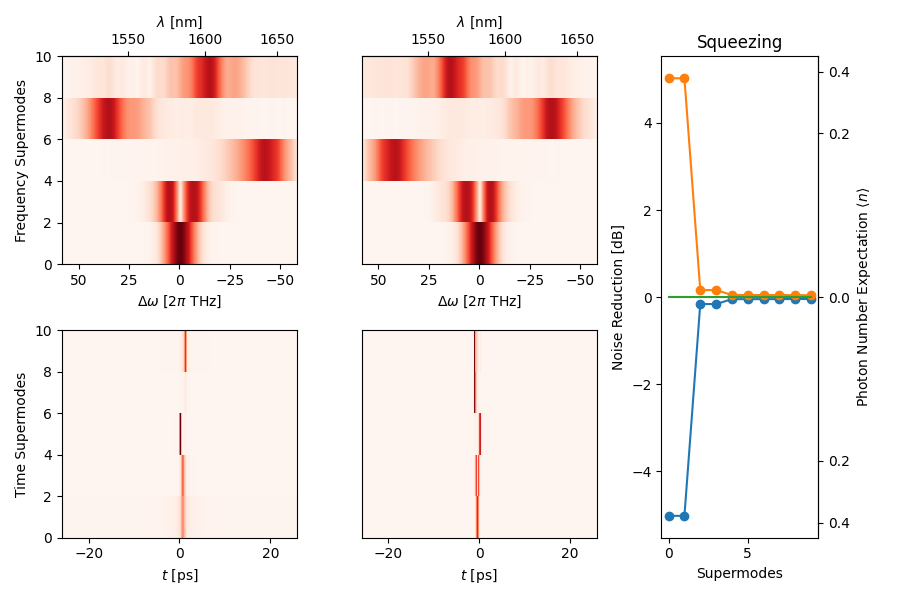

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [34]:
last = 10
for abasis, diag in zip(abases, diags):
  fig = plt.figure()
  gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1.5, 1.5, 1])

  ax = fig.add_subplot(gs[0, 0])
  plt.imshow(np.abs(abasis[:last, nt_:]),
             origin="lower", cmap="Reds", aspect="auto", interpolation="none",
             extent=[angFreqMax_, -angFreqMax_, 0, last])
  plt.ylabel("Frequency Supermodes")
  plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")

  fwd, bck = lambda x: 2e-3 * np.pi * c / (x + signalFreq),\
             lambda x: 2e-3 * np.pi * c / x - signalFreq
  secax = ax.secondary_xaxis("top", functions=(fwd, bck))
  secax.set_xlabel("$\lambda$ [nm]")

  ax = fig.add_subplot(gs[0, 1])
  plt.imshow(np.abs(abasis[:last, :nt_]),
             origin="lower", cmap="Reds", aspect="auto", interpolation="none",
             extent=[angFreqMax_, -angFreqMax_, 0, last])
  plt.yticks([])
  plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")

  secax = ax.secondary_xaxis("top", functions=(fwd, bck))
  secax.set_xlabel("$\lambda$ [nm]")

  ax = fig.add_subplot(gs[1, 0])
  plt.imshow(np.abs(fftshift(ifft(fftshift(abasis[:last, nt:]), axis=1))),
             origin="lower", cmap="Reds", aspect="auto", interpolation="none",
             extent=[-tMax * timeScale, tMax * timeScale, 0, last])
  plt.ylabel("Time Supermodes")
  plt.xlabel("$t$ [ps]")

  ax = fig.add_subplot(gs[1, 1])
  plt.imshow(np.abs(fftshift(ifft(fftshift(abasis[:last, :nt_]), axis=1))),
             origin="lower", cmap="Reds", aspect="auto", interpolation="none",
             extent=[-tMax * timeScale, tMax * timeScale, 0, last])
  plt.yticks([])
  plt.xlabel("$t$ [ps]")

  ax = fig.add_subplot(gs[:, 2])
  plt.plot(20 * np.log10(diag[2*nt_:2*nt_+last]), "-o")
  plt.plot(20 * np.log10(diag[:last]), "-o")
  plt.plot(20 * np.log10(diag[2*nt_:2*nt_+last] * diag[:last]))
  plt.title("Squeezing")
  plt.ylabel("Noise Reduction [dB]")
  plt.xlabel("Supermodes")

  fwd, bck = lambda x: np.sinh(np.log(10**(np.abs(x) / 20)))**2 * np.sign(x), \
             lambda x: -20 * np.log10(np.exp(np.arcsinh(np.sqrt(np.abs(x))))) * np.sign(x)
  secax = ax.secondary_yaxis("right", functions=(fwd, bck))
  secax.set_ylabel(r"Photon Number Expectation $\langle n \rangle$")

  plt.tight_layout()
  secax.set_yticks(secax.get_yticks())
  secax.set_yticklabels([label.get_text().lstrip("−") for label in secax.get_yticklabels()])


Compare the total output spectrum of the signal and idler and compare to the contribution from the first supermode pair.

<IPython.core.display.Javascript object>


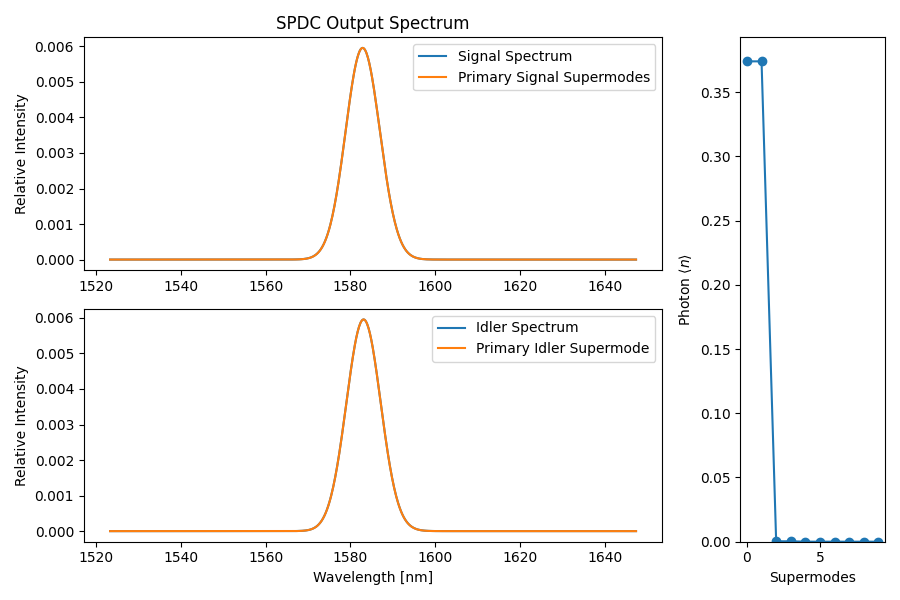

In [35]:
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[4, 1])

for covMtx, abasis, diag in zip(aCovMats, abases, diags):
  fig = plt.figure()
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(fftshift(wavelengthS)[mask_], covMtx[:nt_, :nt_].diagonal().real-0.5, label="Signal Spectrum")
  plt.plot(fftshift(wavelengthS)[mask_], np.abs(abasis[0, :nt_])**2 * (0.5 * (diag[0] - 1/diag[0])**2),
           label="Primary Signal Supermodes")
  plt.legend()
  plt.title("SPDC Output Spectrum")
  plt.ylabel("Relative Intensity")

  ax = fig.add_subplot(gs[1, 0])
  plt.plot(fftshift(wavelengthS)[mask_], covMtx[3*nt_:, 3*nt_:].diagonal().real-0.5, label="Idler Spectrum")
  plt.plot(fftshift(wavelengthS)[mask_], np.abs(abasis[0, nt_:])**2 * (0.5 * (diag[0] - 1/diag[0])**2),
           label="Primary Idler Supermode")
  plt.legend()

  plt.xlabel("Wavelength [nm]")
  plt.ylabel("Relative Intensity")
  
  ax = fig.add_subplot(gs[:, 1])
  plt.plot(np.sinh(np.log(diag[:last]))**2, "-o")
  plt.ylabel(r"Photon $\langle n \rangle$")
  plt.xlabel("Supermodes")
  plt.ylim(0)
  
  plt.tight_layout()


Contribution of each supermode to the joint spectrum.

<IPython.core.display.Javascript object>


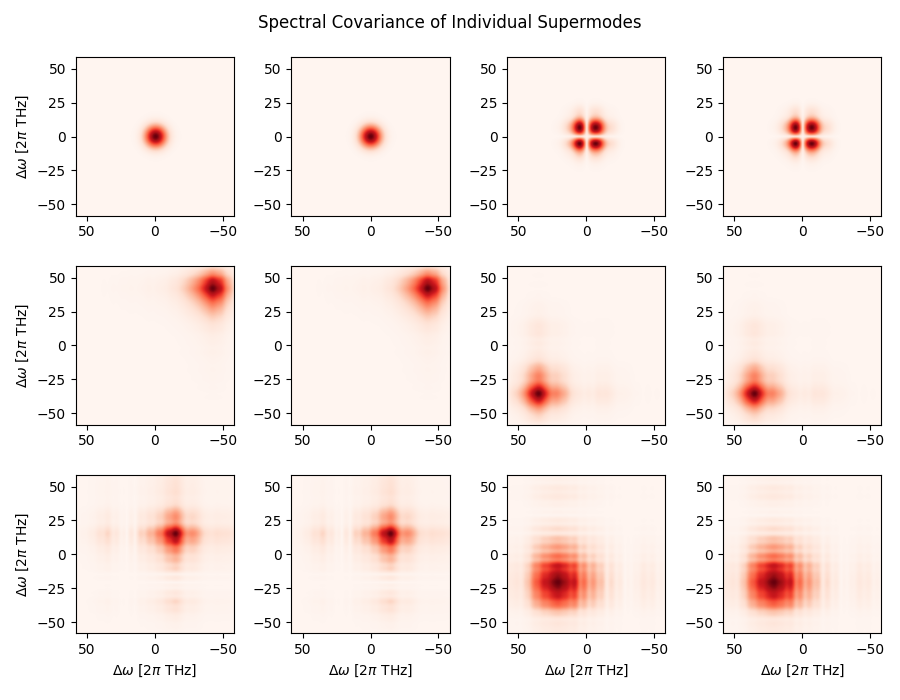

In [36]:
fig = plt.figure(figsize=(9, 7))

for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(np.abs(np.outer(abasis[i, :nt_], abasis[i, nt_:])), "Reds",
             extent=[angFreqMax_, -angFreqMax_, -angFreqMax_, angFreqMax_])
  if i >= 8:     plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")
  if i % 4 == 0: plt.ylabel("$\Delta \omega$ [$2 \pi$ THz]")

plt.suptitle("Spectral Covariance of Individual Supermodes");
plt.tight_layout()

# Compare to the first order approximation

In the weak squeezing regime, the joint spectrum is approximately the product of the phase matching function and parametric gain/coupling strength (due to the pump field):
$$
E_\text{p}(\omega + \omega') \text{ PMF}(\Delta k(\omega, \omega'))
$$
These correspond to the energy and momentum correlations due to conservation criteria.

In [37]:
# Wavenumber mismatch as a function of signal and idler frequency
phaseMatching = (
  (pdcParams["beta1s"] - pdcParams["beta1"]) * omega
  + pdcParams["beta2s"] / 2 * omega**2 + pdcParams["beta3s"] / 6 * omega**3
  + (pdcParams["beta1o"] - pdcParams["beta1"]) * omega[:, None]
  + pdcParams["beta2o"] / 2 * omega[:, None]**2 + pdcParams["beta3o"] / 6 * omega[:, None]**3
  + pdcParams["beta2"] / 2 * (omega + omega[:, None])**2 + pdcParams["beta3o"] / 6 * (omega + omega[:, None])**3
)
phaseMatching = fftshift(phaseMatching, axes=(0, 1))
# Phase matching function as a function of wavenumber
pmFunction = np.exp(-(0.5 * sigmaPMF**2) * phaseMatching**2)

# Pump field to determine the energy matching
pumping = np.abs(fft(pumpProfTemp))
pumping = circulant(pumping / np.max(pumping))[:, ::-1]

# Product of momentum and energy correlation functions
product = pumping * pmFunction

In [38]:
# Remove aliasing
productTraced = product[np.ix_(mask_, mask_)]
prodU, prodS, prodV = np.linalg.svd(productTraced)

<IPython.core.display.Javascript object>


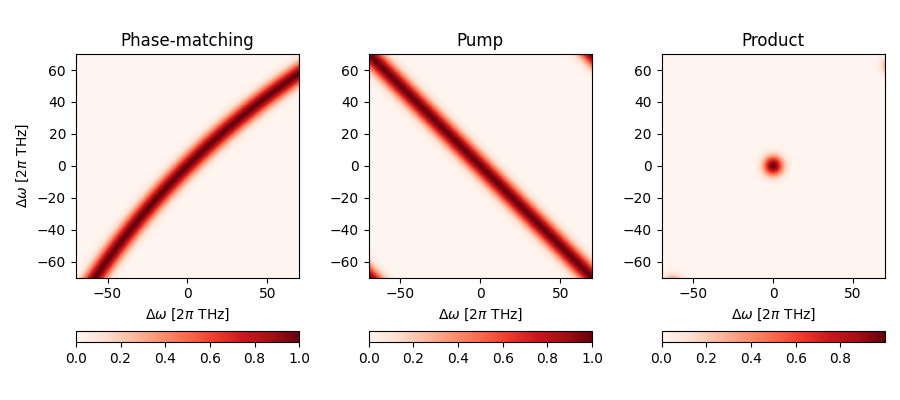

In [39]:
fig = plt.figure(figsize=(9, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(fftshift(angFreq), fftshift(angFreq), pmFunction, rasterized=True, cmap="Reds")
plt.gca().set_aspect("equal")
plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.ylabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.colorbar(orientation="horizontal")
plt.title("Phase-matching")

plt.subplot(1, 3, 2)
plt.pcolormesh(fftshift(angFreq), fftshift(angFreq), pumping, rasterized=True, cmap="Reds")
plt.gca().set_aspect("equal")
plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.colorbar(orientation="horizontal")
plt.title("Pump")

plt.subplot(1, 3, 3)
plt.pcolormesh(fftshift(angFreq), fftshift(angFreq), product, rasterized=True, cmap="Reds")
plt.gca().set_aspect("equal")
plt.xlabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.colorbar(orientation="horizontal")
plt.title("Product")

plt.tight_layout()

Check SVD to check for the presence of higher order modes.

<IPython.core.display.Javascript object>


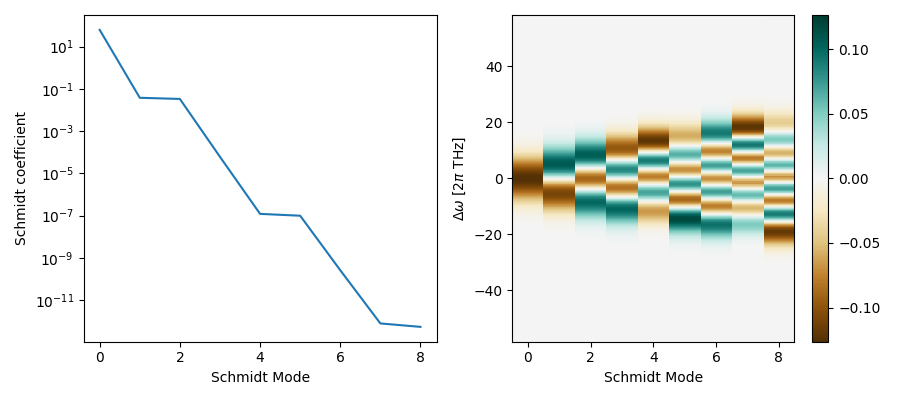

In [40]:
fig = plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(prodS[:9])
plt.yscale("log")
plt.xlabel("Schmidt Mode")
plt.ylabel("Schmidt coefficient")

plt.subplot(1, 2, 2)
vlim = np.max(np.abs(prodU[:, :9]))
plt.imshow(prodU[:, :9], aspect="auto", cmap="BrBG", interpolation="None", vmin=-vlim, vmax=vlim,
           extent=[-0.5, 8.5, -angFreqMax_, angFreqMax_])
plt.xlabel("Schmidt Mode")
plt.ylabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.colorbar()

plt.tight_layout();

Assume we could perfectly dispersion engineer to remove any higher order dispersion:

In [41]:
phaseMatching_ = (
  (pdcParams["beta1s"] - pdcParams["beta1"]) * omega
  + (pdcParams["beta1o"] - pdcParams["beta1"]) * omega[:, None]
)
phaseMatching_ = fftshift(phaseMatching_, axes=(0, 1))
pmFunction_ = np.exp(-(0.5 * sigmaPMF**2) * phaseMatching_**2)

productTraced_ = (pumping * pmFunction_)[np.ix_(mask_, mask_)]

prodU_, prodS_, prodV_ = np.linalg.svd(productTraced_)

This completely suppresses the higher order modes (at least in this perturbative regime).

<IPython.core.display.Javascript object>


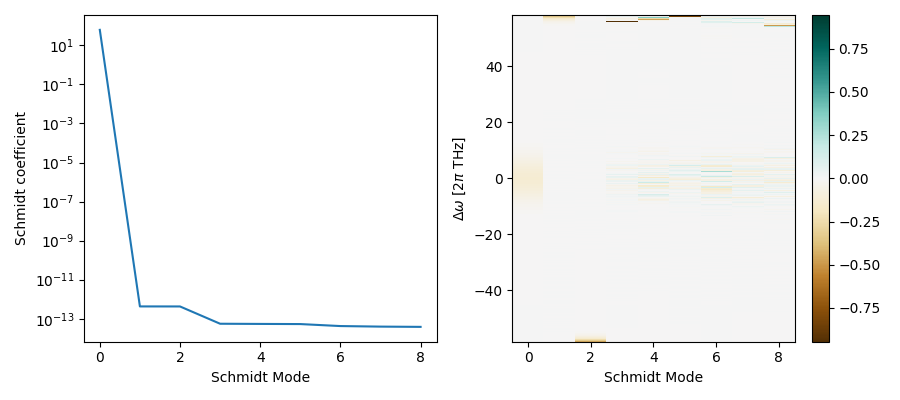

In [42]:
fig = plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(prodS_[:9])
plt.yscale("log")
plt.xlabel("Schmidt Mode")
plt.ylabel("Schmidt coefficient")

plt.subplot(1, 2, 2)
vlim_ = np.max(np.abs(prodU_[:, :9]))
plt.imshow(prodU_[:, :9], aspect="auto", cmap="BrBG", interpolation="None", vmin=-vlim_, vmax=vlim_,
           extent=[-0.5, 8.5, -angFreqMax_, angFreqMax_])
plt.xlabel("Schmidt Mode")
plt.ylabel("$\Delta \omega$ [$2 \pi$ THz]")
plt.colorbar()
plt.tight_layout();